In [1]:
# A bunch of Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision.datasets import DatasetFolder
from pathlib import Path
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchsummary

Tried with the model that was discussed in the previous workshop session( 2 layers of fully connected 3 neurons)

Accuracy was 0.19

Created a Neural Network with Convolution Layers and Max Pool Layers

In [3]:
# Image Size
image_size = (400, 400)
flattened_size = image_size[0] * image_size[1]

# Neural Network
class AnotherImageClassifier(nn.Module):
    def __init__(self, input_channels, hidden_dim, output_dim):
        super(AnotherImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * (image_size[0] // 2) * (image_size[1] // 2), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Using PyTorch Accelaration using Apple Silicon 'MPS' GPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [5]:
# Dimensions for the ImageClassifier
input_channels = 3
hidden_dim = 64
output_dim = 11

In [6]:
model = AnotherImageClassifier(input_channels, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Transformation
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
dataset = ImageFolder(root='./dataset', transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [10]:
# Training loop
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    
    # TQDM
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward Pass and Model Optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({"Loss": loss.item()})
    
    epoch_loss = running_loss / len(data_loader)
    
    # TQDM Update, clears after every iteration
    progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

In [16]:
# Testing the Model

true_labels = []
predicted_labels = []

with torch.no_grad():
    model.eval()  # Setting the model to evaluation

    # Iterate over the test data loader
    for images, labels in tqdm(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


100%|██████████| 215/215 [00:59<00:00,  3.62it/s]


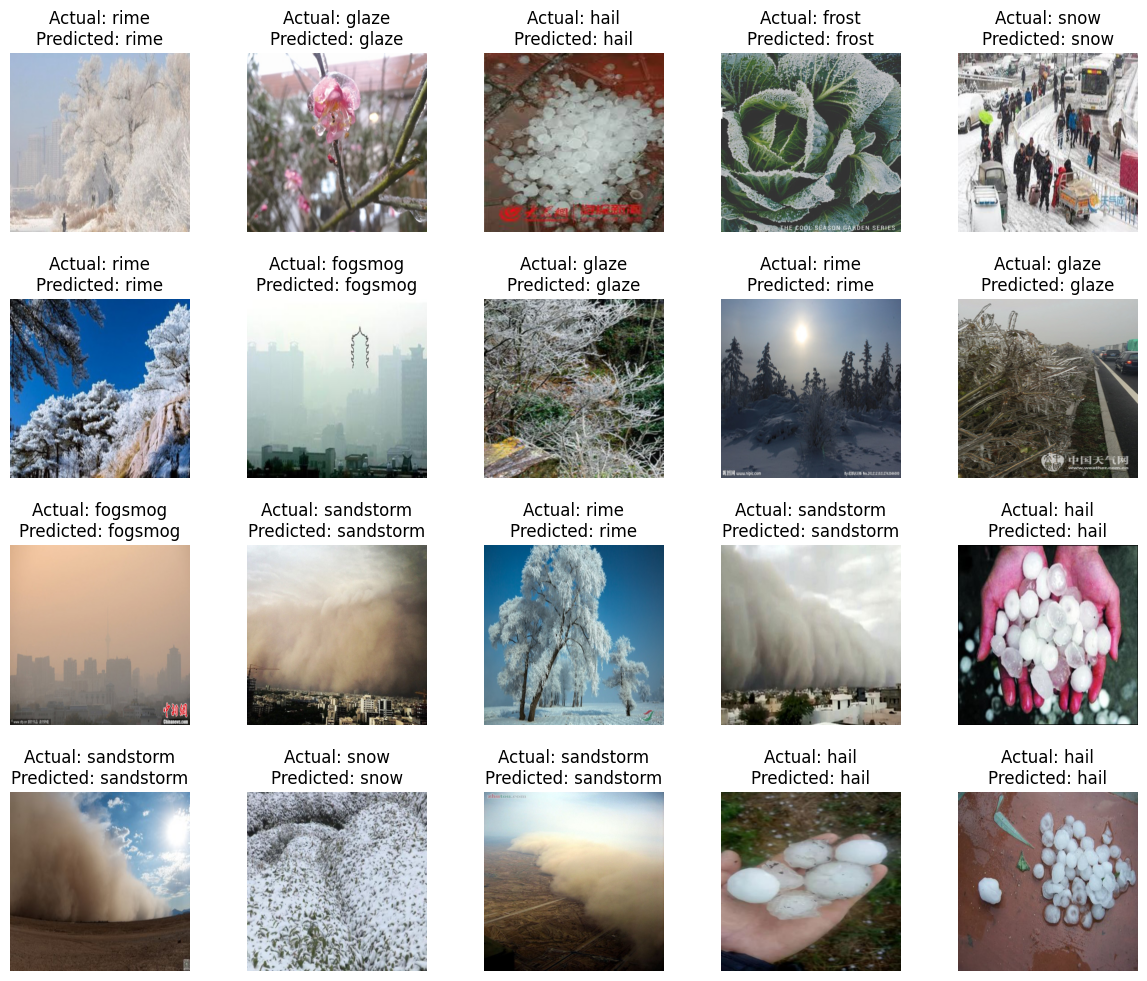

In [20]:
# This chunk of code is to show pictures with actual vs predicted labels

num_images = 20

test_images, test_labels = next(iter(data_loader))
test_images = test_images.to(device)

with torch.no_grad():
    outputs = model(test_images)
    _, predicted = torch.max(outputs, 1)

test_images = test_images.cpu().numpy()
test_labels = test_labels.numpy()
predicted_labels = predicted.cpu().numpy()

# Plot to display images
fig, axs = plt.subplots(4, 5, figsize=(12, 10))
fig.tight_layout()

for i in range(num_images):
    image = test_images[i].transpose(1, 2, 0) / 2 + 0.5  
    true_label = dataset.classes[test_labels[i]]
    predicted_label = dataset.classes[predicted_labels[i]]

    ax = axs[i // 5, i % 5]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"Actual: {true_label}\nPredicted: {predicted_label}")

plt.show()

In [17]:
confusion = confusion_matrix(true_labels, predicted_labels)

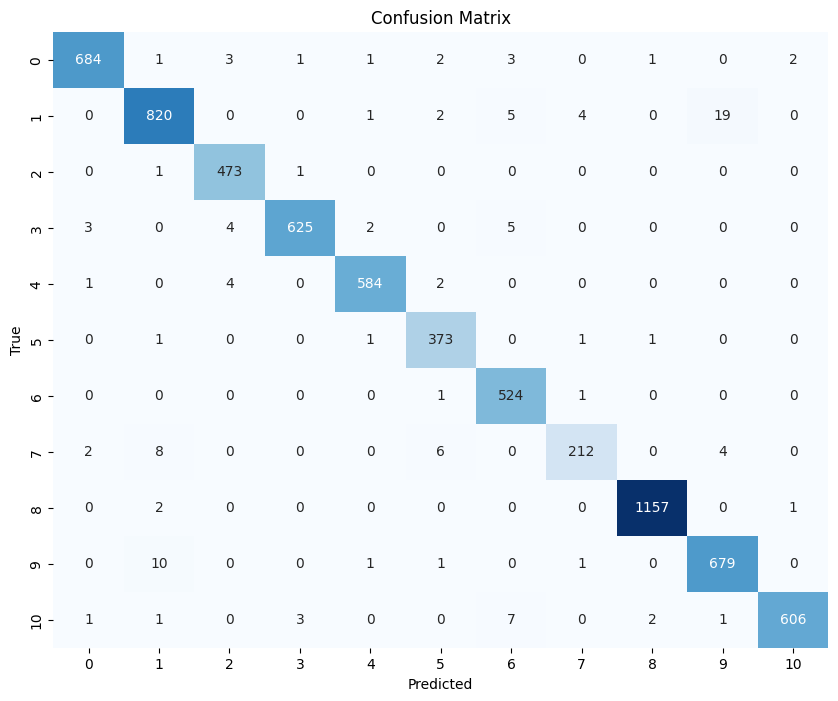

In [18]:
# Confusion Matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [19]:
# Classification Report
report = classification_report(true_labels, predicted_labels)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       698
           1       0.97      0.96      0.97       851
           2       0.98      1.00      0.99       475
           3       0.99      0.98      0.99       639
           4       0.99      0.99      0.99       591
           5       0.96      0.99      0.98       377
           6       0.96      1.00      0.98       526
           7       0.97      0.91      0.94       232
           8       1.00      1.00      1.00      1160
           9       0.97      0.98      0.97       692
          10       1.00      0.98      0.99       621

    accuracy                           0.98      6862
   macro avg       0.98      0.98      0.98      6862
weighted avg       0.98      0.98      0.98      6862

